In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

In [20]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)), 
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-10, 10))], p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root=os.path.join('./ant-and-bee/hymenoptera_data', 'train'), transform=transform)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join('./ant-and-bee/hymenoptera_data', 'val'), transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=1)
data = next(iter(train_loader))
images, _ = data
images.to(torch.device("cuda"))
mean = images.mean(dim=(0, 2, 3))
std = images.std(dim=(0, 2, 3))

normalize = transforms.Normalize(mean=mean, std=std)


train_dataset.transform = transforms.Compose([transform, normalize])
test_dataset.transform = transforms.Compose([test_transform, normalize])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



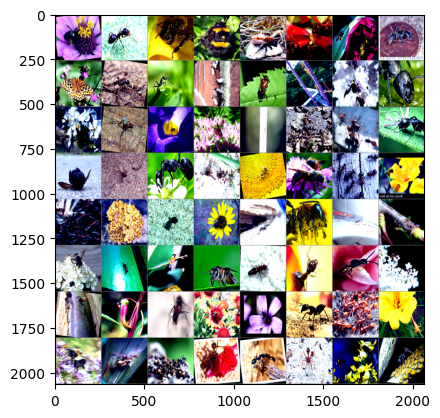

In [42]:
import numpy as np
batch=next(iter(train_loader))
images,labels=batch
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [43]:
d=next(iter(train_loader))
model = torchvision.models.resnet18(weights=True)
for param in model.parameters():
    param.requires_grad=False

model.fc=nn.Sequential(
    nn.Linear(in_features=512, out_features=1),
)
for param in model.layer4.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

In [38]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001
min_loss=100000000
train_losses=[]
test_losses=[]
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

num_epochs = 20
losses = []
info=dict()
val_losses=[]
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels=labels.float()
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()

        outputs = model(inputs)
        outputs=outputs.squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # print statistics
        # running_loss += loss.item()
        losses.append(loss.item())
        
#     print(epoch, np.mean(np.asanyarray(train_losses)))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            outputs=outputs.squeeze()
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            binary_predictions = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0)
            correct += np.sum(binary_predictions.cpu().numpy() == labels.cpu().numpy())

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy * 100:.2f}% Train loss', np.mean(np.asanyarray(losses)))
    train_losses.append(np.mean(losses))
    test_losses.append(np.mean(val_losses))
    if np.mean(np.asanyarray(val_losses)) < min_loss:
        min_loss = np.mean(np.asanyarray(val_losses))
        torch.save(model.state_dict(), './ant_vs_bees.pth')

    info['train_loss']=train_losses
    info['test_loss']=test_losses
    info['epochs']=range(epoch+1)
print('Finished Training')

Epoch 1/20, Validation Accuracy: 54.25% Train loss 2.1458652652800083
Epoch 2/20, Validation Accuracy: 51.63% Train loss 1.497128689661622
Epoch 3/20, Validation Accuracy: 58.82% Train loss 1.1909705760578315
Epoch 4/20, Validation Accuracy: 86.27% Train loss 1.0276704831048846
Epoch 5/20, Validation Accuracy: 88.89% Train loss 0.9031392611563206
Epoch 6/20, Validation Accuracy: 90.85% Train loss 0.8113626887400945
Epoch 7/20, Validation Accuracy: 86.93% Train loss 0.7468481329934937
Epoch 8/20, Validation Accuracy: 88.89% Train loss 0.6851659966632724
Epoch 9/20, Validation Accuracy: 89.54% Train loss 0.633783932775259
Epoch 10/20, Validation Accuracy: 88.24% Train loss 0.5891851158812642
Epoch 11/20, Validation Accuracy: 91.50% Train loss 0.5525280694392595
Epoch 12/20, Validation Accuracy: 84.31% Train loss 0.5185736153895656
Epoch 13/20, Validation Accuracy: 90.85% Train loss 0.49283265594679576
Epoch 14/20, Validation Accuracy: 84.97% Train loss 0.471494434534439
Epoch 15/20, Vali

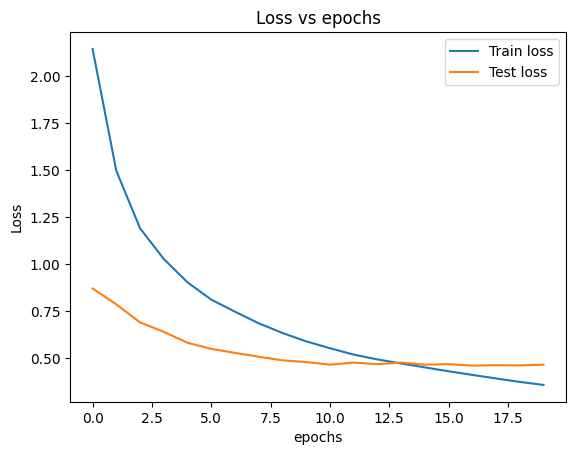

In [39]:
def plot(info):
    plt.plot(info['epochs'], info['train_loss'], label='Train loss')
    plt.plot(info['epochs'], info['test_loss'], label='Test loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs epochs')
    plt.legend()
    plt.show()
plot(info)

Confusion Matrix:


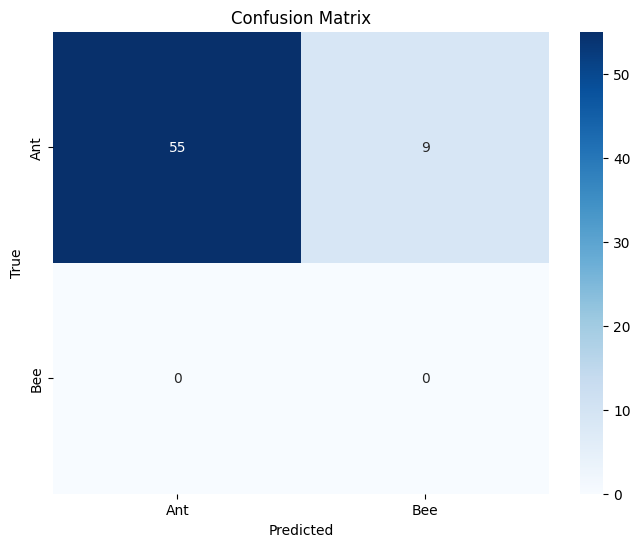

In [41]:
PATH = './ant_vs_bees.pth'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
images,labels=next(iter(test_loader))
model.load_state_dict(torch.load(PATH))
device = torch.device("cuda")
images=images.to(device)
outputs = model(images)
outputs=outputs.cpu()
predictions = (torch.sigmoid(outputs) > 0.5).int()
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
class_names = ["Ant", "Bee"]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()